In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

num_classes = 1
hidden_layer_size = 10
batch_size = 1
sample_size = 1
sequence_length = 1
num_LSTM_layers = 10
learning_rate = 0.01


def norm_array(array):
    mean = np.mean(array)
    stddev = np.sqrt(np.sum(np.square(array - mean)) / len(array - 1))
    normalized_array = ((array - mean) / stddev)
    return normalized_array, mean.reshape(batch_size), stddev.reshape(batch_size)


def test_decoder(array, mean, stddev):
    return (array * stddev) + mean

def get_linear_layer(vector):
    return(tf.matmul(vector, Wl) + bl)
def train_test_split(X, y, train_size):
    X_train = X[:int(len(X) // (1 / train_size))]
    y_train = y[:int(len(y) // (1 / train_size))]
    X_test = X[int(len(X) // (1 / train_size)):]
    y_test = y[int(len(y) // (1 / train_size)):]
    return X_train, X_test, y_train, y_test

def data_labels(data, sample_size, batch_size):
    labels = data.iloc[:sample_size, 2:]
    data = data.iloc[:sample_size, 1:]
    indeces = np.random.choice(len(data), size=batch_size, replace=False)
    batch_x = np.array(data.loc[indeces[0]][data.loc[indeces[0]][:] > 0][:-1])
    batch_y = np.array(labels.loc[indeces[0]][labels.loc[indeces[0]][:] > 0])
    return (batch_x, batch_y)


def cell_list(num_LSTM_layers):
    for i in range(num_LSTM_layers):
        cell_list = []
        cell_list.append(tf.contrib.rnn.BasicLSTMCell(hidden_layer_size, forget_bias=1.0))
    return cell_list

In [9]:
data = pd.read_csv(r"C:\M4datasets\Yearly-train.csv")
data_x, data_y = data_labels(data, sample_size = sample_size, batch_size = batch_size)
print(data_x)

[5172.1 5133.5 5186.9 5084.6 5182.  5414.3 5576.2 5752.9 5955.2 6087.8
 6238.9 6317.2 6262.7 6361.  6427.4 6654.9 6835.4 6925.5 7073.5 7144.
 7230.6 7349.6 7339.2 7250.8 7294.6 7393.9 7560.9 7651.4 7587.3 7530.5]


In [12]:
tf.reset_default_graph()

with tf.name_scope("Training_data"):
    inputs = tf.placeholder(tf.float32,shape=[batch_size, None, sequence_length], name='inputs')
    y = tf.placeholder(tf.float32, shape=[batch_size], name='inputs')

with tf.variable_scope('LSTM_cell'):  
    cell = tf.contrib.rnn.MultiRNNCell(cells=cell_list(num_LSTM_layers), state_is_tuple=True)
    outputs, states = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32)

with tf.name_scope('Linear_weights_and_biases'):
    Wl = tf.Variable(tf.truncated_normal([hidden_layer_size, num_classes], mean = 0, stddev = 0.01))
    bl = tf.Variable(tf.truncated_normal([num_classes], mean = 0, stddev = 0.1))


with tf.name_scope('Means_and_standard_deviations'):
    mean = tf.placeholder(tf.float32, shape = [batch_size])
    stddev = tf.placeholder(tf.float32, shape = [batch_size])

linear_output = get_linear_layer(outputs[0])
final_output = test_decoder(linear_output, mean, stddev)[-1]
mse = tf.reduce_mean(tf.squared_difference(final_output, y))
train_step = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(mse)



sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
mse_list = []

for i in range(6000):  
    batch_x, batch_y = data_labels(data, sample_size = sample_size, batch_size = batch_size)
    data_train, data_test, labels_train, labels_test = train_test_split(batch_x, batch_y, train_size = 0.8)
    
    normed_data_train, mean_batch, stddev_batch = norm_array(data_train)
    
    normed_data_train = normed_data_train.reshape(batch_size, len(data_train), sequence_length)
    
    label = labels_train[-1].reshape(batch_size)
    sess.run(train_step, feed_dict = {inputs : normed_data_train,\
                                            y : label,  mean : mean_batch, stddev : stddev_batch})
    mse_batch = sess.run(mse, feed_dict = {inputs : normed_data_train,\
                                            y : label,  mean : mean_batch, stddev : stddev_batch})
    for j in range(len(data_test)):
        data_train =  np.append(data_train, data_test[j])
        labels_train = np.append(labels_train, labels_test[j])
        normed_data_train, mean_batch, stddev_batch = norm_array(data_train)
        normed_data_train = normed_data_train.reshape(batch_size, len(data_train), sequence_length)

        label = labels_train[-1].reshape(batch_size)
        sess.run(train_step, feed_dict = {inputs : normed_data_train, y : label, mean : mean_batch, stddev : stddev_batch})
        mse_batch += sess.run(mse, feed_dict = {inputs : normed_data_train,\
                                            y : label,  mean : mean_batch, stddev : stddev_batch})
    mse_batch = mse_batch / len(data_test)
    if  i % 100 == 0:
        print(mse_batch)
        mse_list.append(mse_batch)
    if mse_batch < 5000:
        learning_rate == learning_rate / ((i+1) * 10000)
x = range(1, len(mse_list))
plt.plot(a, mse_list[1:])
plt.show()
       


1246476.0833333333


KeyboardInterrupt: 

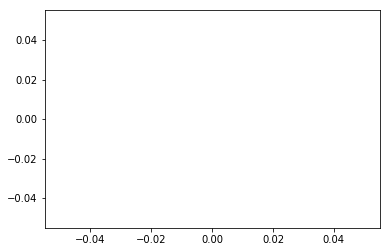

In [5]:
a = range(5, len(mse_list))
plt.plot(a, mse_list[5:])
plt.show()